In [1]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import SVR
from sklearn.datasets import make_regression, make_circles
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler

sns.set(style="whitegrid")
%matplotlib inline

In [2]:
# --- GLOBAL DATA FOR ALL SVM EXAMPLES ---
# This cell ensures X, y, X_plot are always defined for all SVM regression code
import numpy as np
from sklearn.datasets import make_regression

# If not already defined, create a simple regression dataset
try:
    X
    y
except NameError:
    X, y = make_regression(n_samples=80, n_features=1, noise=20, random_state=42)

# X_plot is always a sorted version of X for plotting
X_plot = np.sort(X, axis=0)

# Regression using Support Vector Machines (SVM)

This notebook presents an introduction to regression using SVM, with visual explanations and example code. We will cover:
1. What is SVM?
2. Common applications of SVM
3. How SVM works: epsilon tube and support points
4. Kernel-based SVM regression and data projection
5. SVM regression: effect of support points, epsilon, and C

Let's get started!

## 1. Import Required Libraries
We will use numpy, matplotlib, seaborn, and scikit-learn for data manipulation, visualization, and SVM regression.

## 2. What is SVM?
Support Vector Machines (SVM) are supervised learning algorithms used for both classification and regression tasks.

**Key concepts:**
- **Hyperplane:** The decision boundary that separates different classes (for classification) or fits the data (for regression).
- **Margin:** The distance between the hyperplane and the closest data points from each class. SVM aims to maximize this margin.
- **Support Vectors:** The data points that lie closest to the hyperplane and influence its position and orientation.
- **Kernel Trick:** A technique that allows SVMs to perform well with non-linear data by implicitly mapping it to a higher-dimensional space.

SVMs are powerful because they focus on the most critical data points (support vectors) and can handle both linear and non-linear problems.

## 3. Common Applications of SVM
SVMs are widely used for:
- **Classification**: Separating data into categories (e.g., spam detection, image recognition)
- **Regression**: Predicting continuous values (e.g., stock prices, house prices)

Below is a simple example of SVM for classification, showing the decision boundary, margin, and support vectors.

## 4. How SVM Works

### Primal problem ε-SVR

We introduce slack variables $\xi_i, \xi_i^*$ to allow errors outside the tube.

$$
\begin{aligned}
\min_{w,b,\xi,\xi^*} 
& \quad \tfrac{1}{2}\|w\|^2 + C \sum_{i=1}^n (\xi_i + \xi_i^*) \\
\text{s.t. } 
& \quad y_i - w^\top \varphi(x_i) - b \le \varepsilon + \xi_i, \quad i=1,\ldots,n \\
& \quad w^\top \varphi(x_i) + b - y_i \le \varepsilon + \xi_i^*, \quad i=1,\ldots,n \\
& \quad \xi_i \ge 0, \;\; \xi_i^* \ge 0, \quad i=1,\ldots,n
\end{aligned}
$$


### Explanation of variables

- $w$: regression weight vector in feature space.  
- $b$: bias/intercept.  
- $\varphi(x)$: mapping of input into higher-dimensional space (allows nonlinearity).  
- $C > 0$: regularization constant (trade-off between flatness and tolerance of errors).  
- $\varepsilon > 0$: insensitivity parameter; errors smaller than $\varepsilon$ are ignored.  
- $\xi_i, \xi_i^*$: slack variables (excess deviations above $\varepsilon$ on each side).  
  - $\xi_i$: violation when prediction is **too low** compared to $y_i$.  
  - $\xi_i^*$: violation when prediction is **too high** compared to $y_i$.  



### Objective function meaning

The objective combines two parts:

- $\tfrac{1}{2}\|w\|^2$: enforces flatness (regularization).  
- $C \sum (\xi_i + \xi_i^*)$: penalizes errors outside the tube.  

### What do these constraints mean in the ε-SVR primal?

Define the residual $r_i = y_i - f(x_i) = y_i - (w^\top \varphi(x_i) + b)$.

The first two constraints together are:
- $y_i - f(x_i) \le \varepsilon + \xi_i$  ⟺  $r_i \le \varepsilon + \xi_i$  
  (limits how far **above** the model can be from $y_i$ in absolute-value terms on the **negative** side)
- $f(x_i) - y_i \le \varepsilon + \xi_i^*$  ⟺  $-r_i \le \varepsilon + \xi_i^*$  
  (limits how far **below** the model can be from $y_i$ on the **positive** side)

And $\xi_i,\xi_i^* \ge 0$ ensure slacks can only **relax** constraints (never tighten them).


### Primal problem ν-SVR

Introduce slacks $ \xi_i, \xi_i^* \ge 0 $ for violations and a free variable $ \rho $ that will act like the tube radius:

$$
\begin{aligned}
\min_{w,b,\xi,\xi^*,\rho}\quad 
& \tfrac{1}{2}\|w\|^2 + C\!\left( \nu \rho + \sum_{i=1}^n (\xi_i + \xi_i^*) \right) \\
\text{s.t.}\quad 
& y_i - (w^\top \varphi(x_i) + b) \le \rho + \xi_i,\quad i=1,\ldots,n \\
& (w^\top \varphi(x_i) + b) - y_i \le \rho + \xi_i^*,\quad i=1,\ldots,n \\
& \xi_i \ge 0,\;\; \xi_i^* \ge 0,\;\; \rho \ge 0.
\end{aligned}
$$

- $ \rho $ is **learned** from the data (not fixed like $ \varepsilon $ in ε-SVR).
- $ \nu $ trades off the size of the tube (via $ \rho $) against the allowable violations and sparsity.


### Interpretation of $ \nu $

- **Sparsity control:** Roughly enforces that at least a fraction $ \nu $ of training samples become **support vectors**.
- **Error control:** Also upper-bounds the fraction of **margin errors** (points outside the tube).
- **Practical tuning:** Choose $ \nu $ to target model complexity (e.g., $ \nu=0.1 $ aims for ~10% SVs), then tune $ C $ (and kernel params) via CV.




### When to prefer ν-SVR over ε-SVR

- You don’t know a good $ \varepsilon $; you prefer setting a **target sparsity/error rate** via $ \nu $.
- You want more direct control over the **number of support vectors** (memory/runtime).

## Epsilon Tube and Support Points
In SVM regression (SVR), the goal is to find a function that deviates from the actual targets by a value no greater than epsilon (ε) for each training point, while being as flat as possible. The points that lie on or outside the epsilon tube are called **support vectors**.

Let's visualize this with an example.

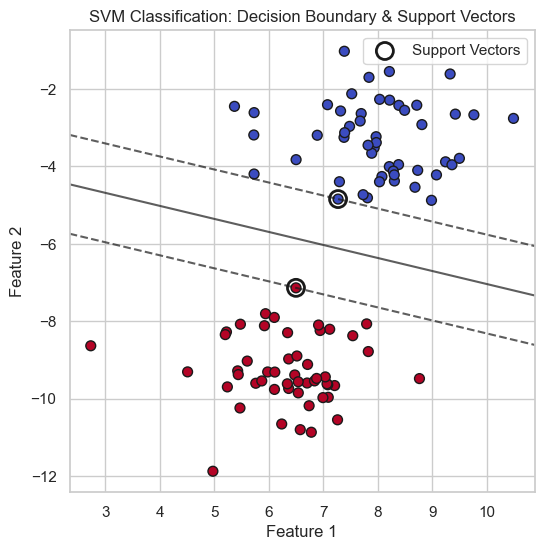

In [3]:
# SVM for classification: decision boundary and support vectors
from sklearn.svm import SVC
from sklearn.datasets import make_blobs
X_cls, y_cls = make_blobs(n_samples=100, centers=2, random_state=6)
svc = SVC(kernel='linear')
svc.fit(X_cls, y_cls)

plt.figure(figsize=(6, 6))
plt.scatter(X_cls[:, 0], X_cls[:, 1], c=y_cls, cmap=plt.cm.coolwarm, s=50, edgecolors='k')
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Create grid to evaluate model
xx = np.linspace(xlim[0], xlim[1], 30)
yy = np.linspace(ylim[0], ylim[1], 30)
YY, XX = np.meshgrid(yy, xx)
xy = np.vstack([XX.ravel(), YY.ravel()]).T
Z = svc.decision_function(xy).reshape(XX.shape)

# Plot decision boundary and margins
ax.contour(XX, YY, Z, colors='k', levels=[-1, 0, 1], alpha=0.7, linestyles=['--', '-', '--'])
# Highlight support vectors
ax.scatter(svc.support_vectors_[:, 0], svc.support_vectors_[:, 1], s=150, linewidth=2, facecolors='none', edgecolors='k', label='Support Vectors')
plt.title('SVM Classification: Decision Boundary & Support Vectors')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.legend()
plt.show()

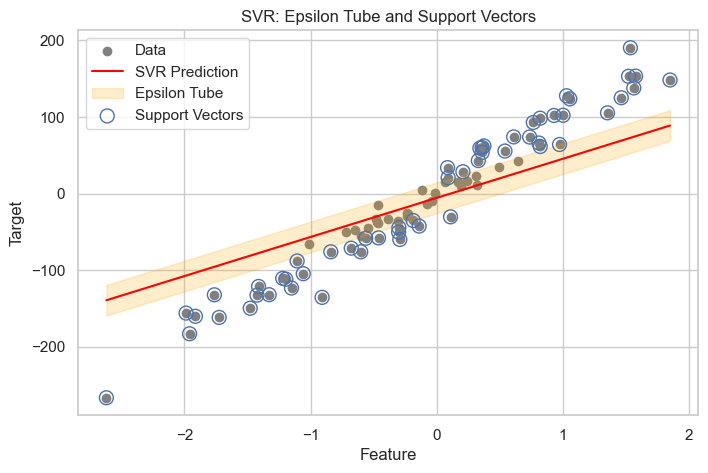

In [4]:
# Visualizing epsilon tube and support vectors in SVR
X_plot = np.sort(X, axis=0)
svr_eps = SVR(kernel='linear', epsilon=20)
svr_eps.fit(X, y)
y_pred = svr_eps.predict(X_plot)

plt.figure(figsize=(8, 5))
plt.scatter(X, y, color='gray', label='Data')
plt.plot(X_plot, y_pred, color='red', label='SVR Prediction')
plt.fill_between(X_plot.ravel(),
                 y_pred - svr_eps.epsilon,
                 y_pred + svr_eps.epsilon,
                 color='orange', alpha=0.2, label='Epsilon Tube')
plt.scatter(X[svr_eps.support_], y[svr_eps.support_],
            facecolors='none', edgecolors='b', s=100, label='Support Vectors')
plt.title('SVR: Epsilon Tube and Support Vectors')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.legend()
plt.show()

## 5. Kerneltrick
SVMs can use kernel functions to handle non-linear data by projecting it into a higher-dimensional space where a linear separation (or fit) is possible.

**Note:** In practice, the kernel trick computes inner products in a high-dimensional space without explicitly mapping the data. Here, we use a simple polynomial feature mapping to illustrate how data can become linearly separable in a higher-dimensional space.

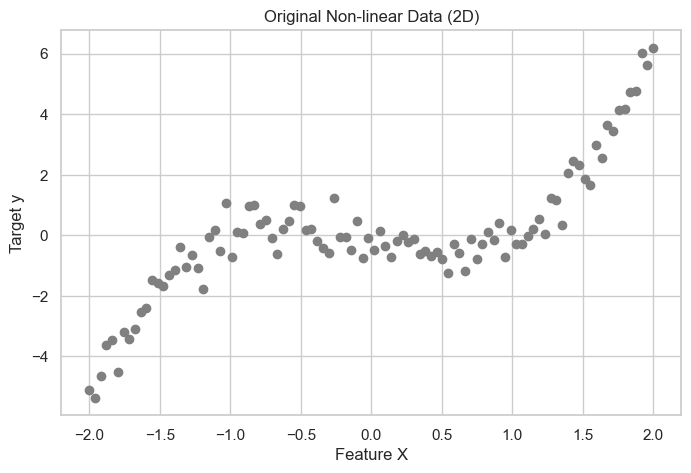

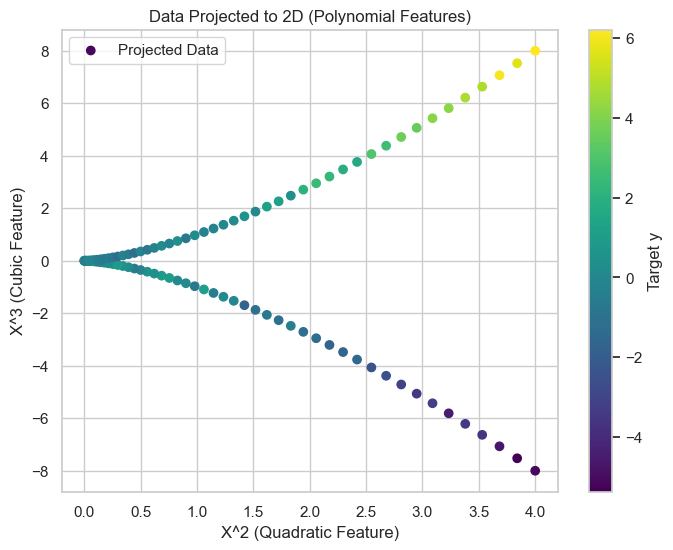

In [5]:
# Simple non-linear data
np.random.seed(0)
X_poly = np.linspace(-2, 2, 100).reshape(-1, 1)
y_poly = X_poly[:, 0] ** 3 - X_poly[:, 0] + np.random.normal(0, 0.5, X_poly.shape[0])

# 1. Plot original data in 2D
plt.figure(figsize=(8, 5))
plt.scatter(X_poly, y_poly, color='gray', label='Original Data')
plt.title('Original Non-linear Data (2D)')
plt.xlabel('Feature X')
plt.ylabel('Target y')
# 2. Project data into 2D using polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=3, include_bias=False)
X_poly_proj = poly.fit_transform(X_poly)

plt.figure(figsize=(8, 6))
plt.scatter(X_poly_proj[:, 1], X_poly_proj[:, 2], c=y_poly, cmap='viridis', label='Projected Data')
plt.xlabel('X^2 (Quadratic Feature)')
plt.ylabel('X^3 (Cubic Feature)')
plt.title('Data Projected to 2D (Polynomial Features)')
plt.colorbar(label='Target y')
plt.legend()
plt.show()

In [6]:
# Define X and y for regression examples if not already defined
try:
    X
    y
except NameError:
    # Simple 1D regression data
    X = np.linspace(-5, 5, 40).reshape(-1, 1)
    y = 3 * X[:, 0] + np.random.normal(0, 2, X.shape[0])

## 6. SVM Regression: Effect of Support Points, Epsilon, and C
The regression line in SVR is influenced by the support vectors, epsilon (ε), and the regularization parameter C:
- **Epsilon (ε)**: Width of the tube. Larger ε ignores more errors, resulting in fewer support vectors and a smoother fit.
- **C**: Penalty for errors outside the tube. Larger C means less tolerance for errors, leading to more support vectors and a tighter fit.

Let's visualize the effect of changing ε and C.

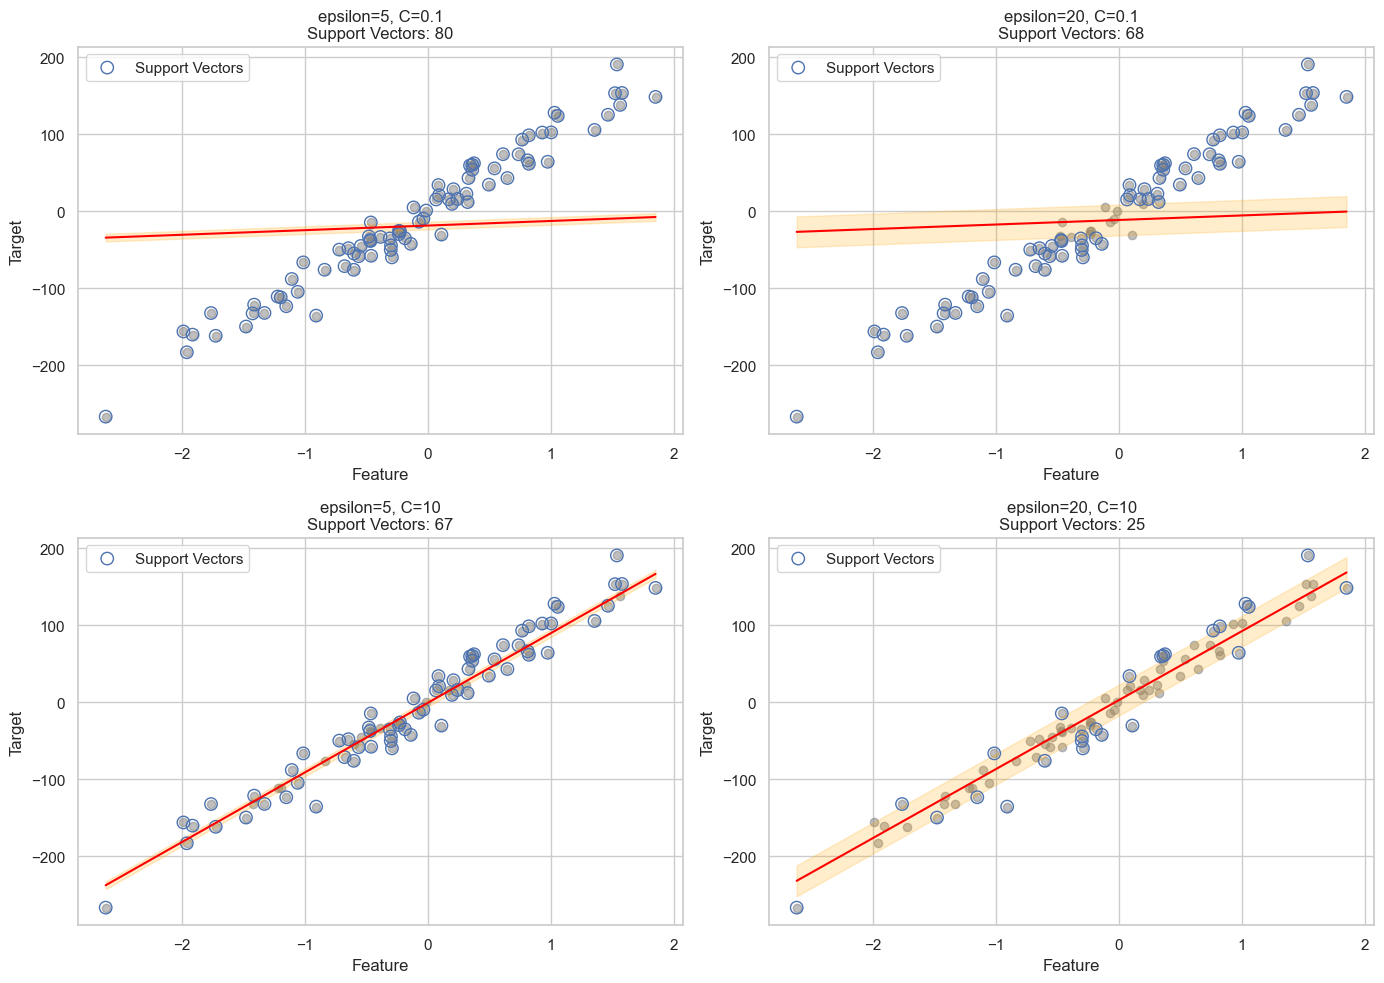

In [7]:
# Effect of epsilon and C on SVR
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
params = [(5, 0.1), (20, 0.1), (5, 10), (20, 10)]
for ax, (eps, C) in zip(axes.ravel(), params):
    svr = SVR(kernel='linear', epsilon=eps, C=C)
    svr.fit(X, y)
    y_pred = svr.predict(X_plot)
    ax.scatter(X, y, color='gray', alpha=0.5)
    ax.plot(X_plot, y_pred, color='red')
    ax.fill_between(X_plot.ravel(),
                    y_pred - eps,
                    y_pred + eps,
                    color='orange', alpha=0.2)
    ax.scatter(X[svr.support_], y[svr.support_],
               facecolors='none', edgecolors='b', s=80, label='Support Vectors')
    ax.set_title(f'epsilon={eps}, C={C}\nSupport Vectors: {len(svr.support_)}')
    ax.set_xlabel('Feature')
    ax.set_ylabel('Target')
    ax.legend()
plt.tight_layout()
plt.show()

# 7 Example

## 7.1 Task
Predict cooling and heating load using SVR and LR with the given features and targets. Featers are representing building construction, table is given below:

| Variable Name | Tole | Type | Description | Units | Missing Values |
| --- | --- | --- | --- | --- | --- |
| X1 | Feature | Continous | Relative Compactness | empthy | no |
| X2 | Feature | Continous | Surface Area | empthy | no |
| X3 | Feature | Continous | Wall Area | empthy | no |
| X4 | Feature | Continous | Roof Area | empthy | no |
| X5 | Feature | Continous | Overall Height | empthy | no |
| X6 | Feature | Integer | Orientation | empthy | no |
| X7 | Feature | Continous | Glazing Area | empthy | no |
| X8 | Feature | Integer | Glazing Area Distribution | empthy | no |
| Y1 | Target | Continous | Heating Load | empthy | no |
| Y2 | Target | Continous | Cooling Load | empthy | no |

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



In [34]:
# Load dataset
file_path = "energy+efficiency/ENB2012_data.xlsx"
df = pd.read_excel(file_path)




🔹 Linear Regression
Linear Regression - Heating Load (Y1): RMSE=3.025, MAE=2.182, R²=0.912
Linear Regression - Cooling Load (Y2): RMSE=3.145, MAE=2.195, R²=0.893

🔹 SVR
SVR - Heating Load (Y1): RMSE=0.735, MAE=0.561, R²=0.995
SVR - Cooling Load (Y2): RMSE=1.787, MAE=1.137, R²=0.966


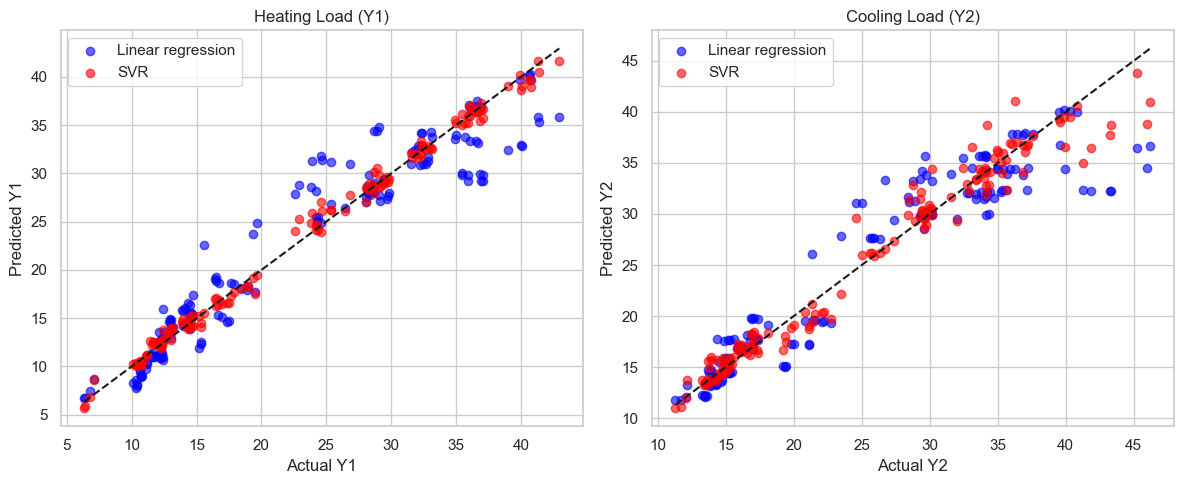

In [35]:
# Features: first 8 columns, Targets: Y1 and Y2
X = df.iloc[:, 0:8].values
Y = df.iloc[:, 8:10].values  # Heating Load (Y1), Cooling Load (Y2)

# Train/test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Standardization
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

# === 2. Models ===
# Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, Y_train)
Y_pred_lin = lin_reg.predict(X_test_scaled)

# Neural Network (MLP)
mlp = MLPRegressor(hidden_layer_sizes=(64, 32), activation='relu',
                   solver='adam', max_iter=5000, random_state=42)
mlp_multi = MultiOutputRegressor(mlp)
mlp_multi.fit(X_train_scaled, Y_train)
Y_pred_nn = mlp_multi.predict(X_test_scaled)

# Support Vector Regression (SVR)
svr = SVR(kernel="rbf", C=100, epsilon=0.1, gamma="scale")
svr_multi = MultiOutputRegressor(svr)
svr_multi.fit(X_train_scaled, Y_train)
Y_pred_svr = svr_multi.predict(X_test_scaled)

# === 3. Evaluation function ===
def evaluate_multi(name, Y_true, Y_pred):
    results = {}
    for i, target in enumerate(["Heating Load (Y1)", "Cooling Load (Y2)"]):
        rmse = np.sqrt(mean_squared_error(Y_true[:, i], Y_pred[:, i]))
        mae = mean_absolute_error(Y_true[:, i], Y_pred[:, i])
        r2 = r2_score(Y_true[:, i], Y_pred[:, i])
        results[target] = (rmse, mae, r2)
        print(f"{name} - {target}: RMSE={rmse:.3f}, MAE={mae:.3f}, R²={r2:.3f}")
    return results

print("\n🔹 Linear Regression")
res_lin = evaluate_multi("Linear Regression", Y_test, Y_pred_lin)

# print("\n🔹 Neural Network")
# res_nn = evaluate_multi("Neural Network", Y_test, Y_pred_nn)

print("\n🔹 SVR")
res_svr = evaluate_multi("SVR", Y_test, Y_pred_svr)

# === 4. Visualization ===
fig, axes = plt.subplots(1, 2, figsize=(12,5))

# Heating Load (Y1)
axes[0].scatter(Y_test[:,0], Y_pred_lin[:,0], color="blue", alpha=0.6, label="Linear regression")
# axes[0].scatter(Y_test[:,0], Y_pred_nn[:,0], color="green", alpha=0.6, label="Neural Net")
axes[0].scatter(Y_test[:,0], Y_pred_svr[:,0], color="red", alpha=0.6, label="SVR")
axes[0].plot([Y_test[:,0].min(), Y_test[:,0].max()],
             [Y_test[:,0].min(), Y_test[:,0].max()], "k--")
axes[0].set_xlabel("Actual Y1")
axes[0].set_ylabel("Predicted Y1")
axes[0].set_title("Heating Load (Y1)")
axes[0].legend()

# Cooling Load (Y2)
axes[1].scatter(Y_test[:,1], Y_pred_lin[:,1], color="blue", alpha=0.6, label="Linear regression")
# axes[1].scatter(Y_test[:,1], Y_pred_nn[:,1], color="green", alpha=0.6, label="Neural Net")
axes[1].scatter(Y_test[:,1], Y_pred_svr[:,1], color="red", alpha=0.6, label="SVR")
axes[1].plot([Y_test[:,1].min(), Y_test[:,1].max()],
             [Y_test[:,1].min(), Y_test[:,1].max()], "k--")
axes[1].set_xlabel("Actual Y2")
axes[1].set_ylabel("Predicted Y2")
axes[1].set_title("Cooling Load (Y2)")
axes[1].legend()

plt.tight_layout()
plt.show()


🔹 SVR (C=0.01, eps=0.1)
SVR (C=0.01, eps=0.1) - Heating Load (Y1): RMSE=10.240, MAE=8.547, R²=-0.006
SVR (C=0.01, eps=0.1) - Cooling Load (Y2): RMSE=9.356, MAE=8.001, R²=0.055

🔹 SVR (C=0.1, eps=0.1)
SVR (C=0.1, eps=0.1) - Heating Load (Y1): RMSE=5.954, MAE=4.328, R²=0.660
SVR (C=0.1, eps=0.1) - Cooling Load (Y2): RMSE=5.657, MAE=4.225, R²=0.655

🔹 SVR (C=1, eps=0.1)
SVR (C=1, eps=0.1) - Heating Load (Y1): RMSE=2.823, MAE=1.889, R²=0.924
SVR (C=1, eps=0.1) - Cooling Load (Y2): RMSE=3.259, MAE=2.125, R²=0.885

🔹 SVR (C=10, eps=0.1)
SVR (C=10, eps=0.1) - Heating Load (Y1): RMSE=2.258, MAE=1.256, R²=0.951
SVR (C=10, eps=0.1) - Cooling Load (Y2): RMSE=2.694, MAE=1.689, R²=0.922

🔹 SVR (C=100, eps=0.1)
SVR (C=100, eps=0.1) - Heating Load (Y1): RMSE=0.735, MAE=0.561, R²=0.995
SVR (C=100, eps=0.1) - Cooling Load (Y2): RMSE=1.787, MAE=1.137, R²=0.966

🔹 SVR (C=1000, eps=0.1)
SVR (C=1000, eps=0.1) - Heating Load (Y1): RMSE=0.458, MAE=0.345, R²=0.998
SVR (C=1000, eps=0.1) - Cooling Load (Y2): R

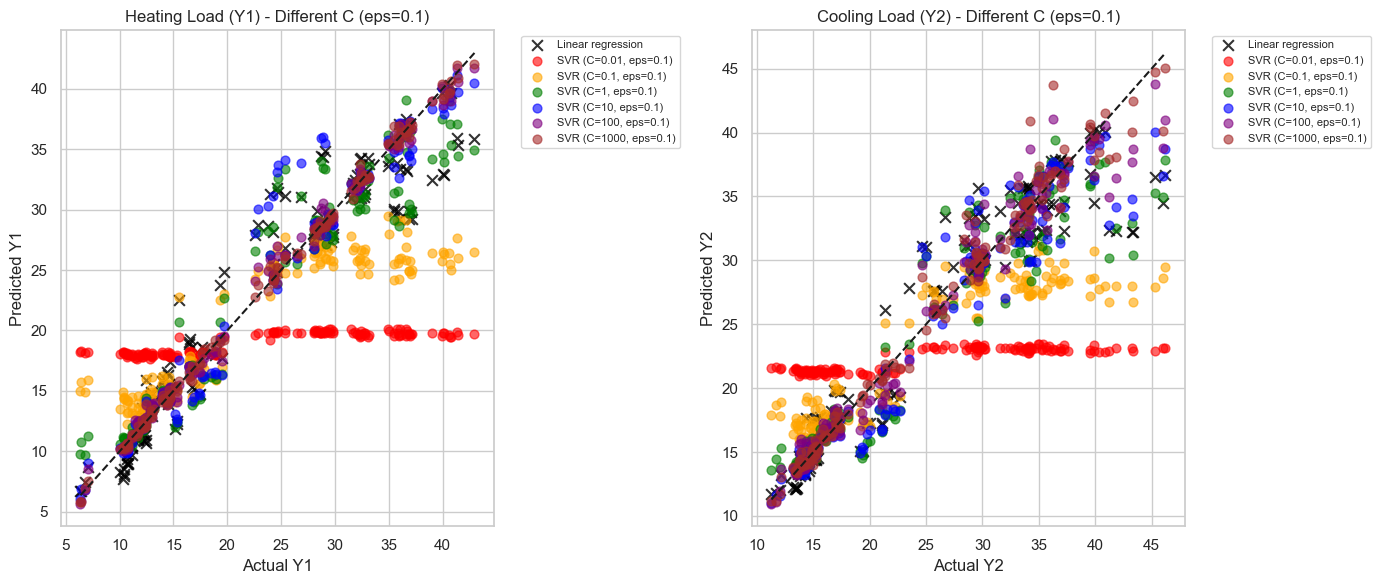

In [36]:
# === SVR with fixed epsilon=0.1 and varying C ===
svr_params_C = [
    {"C": 0.01, "epsilon": 0.1},
    {"C": 0.1,  "epsilon": 0.1},
    {"C": 1,    "epsilon": 0.1},
    {"C": 10,   "epsilon": 0.1},
    {"C": 100,  "epsilon": 0.1},
    {"C": 1000, "epsilon": 0.1},
    # {"C": 10000,"epsilon": 0.1},  # intentionally very large (bad)
]

Y_pred_svr_C = {}

for params in svr_params_C:
    svr = SVR(kernel="rbf", C=params["C"], epsilon=params["epsilon"], gamma="scale")
    svr_multi = MultiOutputRegressor(svr)
    svr_multi.fit(X_train_scaled, Y_train)
    Y_pred = svr_multi.predict(X_test_scaled)
    name = f"SVR (C={params['C']}, eps={params['epsilon']})"
    print(f"\n🔹 {name}")
    evaluate_multi(name, Y_test, Y_pred)
    Y_pred_svr_C[name] = Y_pred


# === Visualization: Predictions with different C ===
C_colors = ["red", "orange", "green", "blue", "purple", "brown", "pink"]

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Heating Load (Y1)
axes[0].scatter(Y_test[:,0], Y_pred_lin[:,0],
                color="black", alpha=0.8, label="Linear regression", marker="x", s=60)
for (name, Y_pred), color in zip(Y_pred_svr_C.items(), C_colors):
    axes[0].scatter(Y_test[:,0], Y_pred[:,0],
                    color=color, alpha=0.6, label=name, s=40)
axes[0].plot([Y_test[:,0].min(), Y_test[:,0].max()],
             [Y_test[:,0].min(), Y_test[:,0].max()], "k--")
axes[0].set_xlabel("Actual Y1")
axes[0].set_ylabel("Predicted Y1")
axes[0].set_title("Heating Load (Y1) - Different C (eps=0.1)")
axes[0].legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")

# Cooling Load (Y2)
axes[1].scatter(Y_test[:,1], Y_pred_lin[:,1],
                color="black", alpha=0.8, label="Linear regression", marker="x", s=60)
for (name, Y_pred), color in zip(Y_pred_svr_C.items(), C_colors):
    axes[1].scatter(Y_test[:,1], Y_pred[:,1],
                    color=color, alpha=0.6, label=name, s=40)
axes[1].plot([Y_test[:,1].min(), Y_test[:,1].max()],
             [Y_test[:,1].min(), Y_test[:,1].max()], "k--")
axes[1].set_xlabel("Actual Y2")
axes[1].set_ylabel("Predicted Y2")
axes[1].set_title("Cooling Load (Y2) - Different C (eps=0.1)")
axes[1].legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()


🔹 SVR (C=0.01, eps=0.1)
SVR (C=0.01, eps=0.1) - Heating Load (Y1): RMSE=10.240, MAE=8.547, R²=-0.006
SVR (C=0.01, eps=0.1) - Cooling Load (Y2): RMSE=9.356, MAE=8.001, R²=0.055

🔹 SVR (C=0.1, eps=0.1)
SVR (C=0.1, eps=0.1) - Heating Load (Y1): RMSE=5.954, MAE=4.328, R²=0.660
SVR (C=0.1, eps=0.1) - Cooling Load (Y2): RMSE=5.657, MAE=4.225, R²=0.655

🔹 SVR (C=1, eps=0.1)
SVR (C=1, eps=0.1) - Heating Load (Y1): RMSE=2.823, MAE=1.889, R²=0.924
SVR (C=1, eps=0.1) - Cooling Load (Y2): RMSE=3.259, MAE=2.125, R²=0.885

🔹 SVR (C=10, eps=0.1)
SVR (C=10, eps=0.1) - Heating Load (Y1): RMSE=2.258, MAE=1.256, R²=0.951
SVR (C=10, eps=0.1) - Cooling Load (Y2): RMSE=2.694, MAE=1.689, R²=0.922

🔹 SVR (C=100, eps=0.1)
SVR (C=100, eps=0.1) - Heating Load (Y1): RMSE=0.735, MAE=0.561, R²=0.995
SVR (C=100, eps=0.1) - Cooling Load (Y2): RMSE=1.787, MAE=1.137, R²=0.966

🔹 SVR (C=1000, eps=0.1)
SVR (C=1000, eps=0.1) - Heating Load (Y1): RMSE=0.458, MAE=0.345, R²=0.998
SVR (C=1000, eps=0.1) - Cooling Load (Y2): R

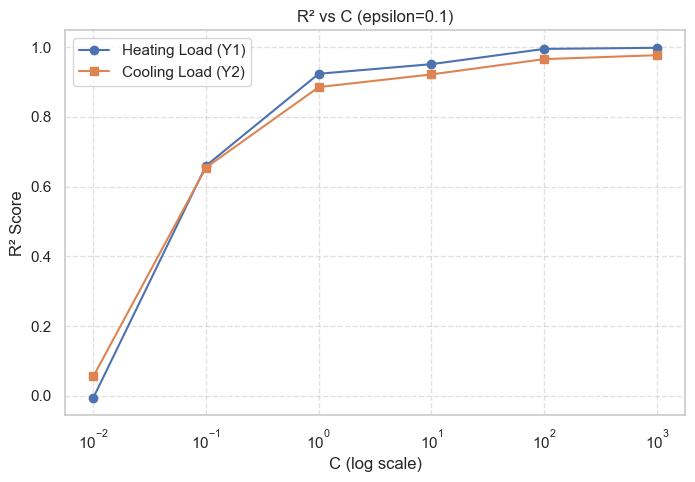

In [38]:
# === Extended SVR parameters for C comparison (fixed eps=0.1) ===
svr_params_C = [
    {"C": 0.01, "epsilon": 0.1},
    {"C": 0.1,  "epsilon": 0.1},
    {"C": 1,    "epsilon": 0.1},
    {"C": 10,   "epsilon": 0.1},
    {"C": 100,  "epsilon": 0.1},
    {"C": 1000, "epsilon": 0.1},
    # {"C": 10000,"epsilon": 0.1},  # intentionally extreme (bad)
]

# Store predictions
Y_pred_svr_C = {}

for params in svr_params_C:
    svr = SVR(kernel="rbf", C=params["C"], epsilon=params["epsilon"], gamma="scale")
    svr_multi = MultiOutputRegressor(svr)
    svr_multi.fit(X_train_scaled, Y_train)
    Y_pred = svr_multi.predict(X_test_scaled)
    name = f"SVR (C={params['C']}, eps={params['epsilon']})"
    print(f"\n🔹 {name}")
    evaluate_multi(name, Y_test, Y_pred)
    Y_pred_svr_C[name] = Y_pred


# === Collect metrics for R² vs C ===
C_values = [p["C"] for p in svr_params_C]
r2_scores_y1_C = []
r2_scores_y2_C = []

for params in svr_params_C:
    name = f"SVR (C={params['C']}, eps={params['epsilon']})"
    Y_pred = Y_pred_svr_C[name]
    r2_y1 = r2_score(Y_test[:,0], Y_pred[:,0])
    r2_y2 = r2_score(Y_test[:,1], Y_pred[:,1])
    r2_scores_y1_C.append(r2_y1)
    r2_scores_y2_C.append(r2_y2)

# === Plot R² vs C ===
plt.figure(figsize=(8,5))
plt.plot(C_values, r2_scores_y1_C, marker="o", label="Heating Load (Y1)")
plt.plot(C_values, r2_scores_y2_C, marker="s", label="Cooling Load (Y2)")
plt.xscale("log")  # C spans orders of magnitude
plt.xlabel("C (log scale)")
plt.ylabel("R² Score")
plt.title("R² vs C (epsilon=0.1)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()



🔹 SVR (C=100, eps=0.001)
SVR (C=100, eps=0.001) - Heating Load (Y1): RMSE=0.734, MAE=0.550, R²=0.995
SVR (C=100, eps=0.001) - Cooling Load (Y2): RMSE=1.788, MAE=1.126, R²=0.965

🔹 SVR (C=100, eps=0.01)
SVR (C=100, eps=0.01) - Heating Load (Y1): RMSE=0.735, MAE=0.552, R²=0.995
SVR (C=100, eps=0.01) - Cooling Load (Y2): RMSE=1.787, MAE=1.125, R²=0.966

🔹 SVR (C=100, eps=0.05)
SVR (C=100, eps=0.05) - Heating Load (Y1): RMSE=0.740, MAE=0.555, R²=0.995
SVR (C=100, eps=0.05) - Cooling Load (Y2): RMSE=1.785, MAE=1.126, R²=0.966

🔹 SVR (C=100, eps=0.1)
SVR (C=100, eps=0.1) - Heating Load (Y1): RMSE=0.735, MAE=0.561, R²=0.995
SVR (C=100, eps=0.1) - Cooling Load (Y2): RMSE=1.787, MAE=1.137, R²=0.966

🔹 SVR (C=100, eps=0.2)
SVR (C=100, eps=0.2) - Heating Load (Y1): RMSE=0.731, MAE=0.564, R²=0.995
SVR (C=100, eps=0.2) - Cooling Load (Y2): RMSE=1.786, MAE=1.153, R²=0.966

🔹 SVR (C=100, eps=1.0)
SVR (C=100, eps=1.0) - Heating Load (Y1): RMSE=1.074, MAE=0.925, R²=0.989
SVR (C=100, eps=1.0) - Cooling

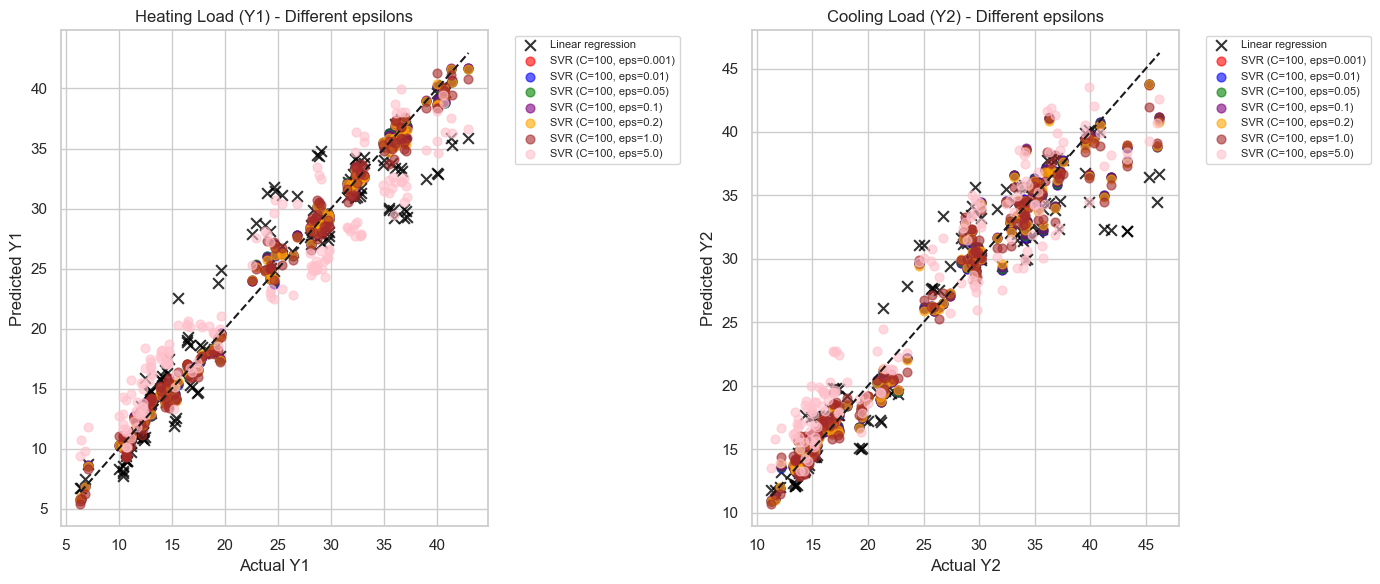

In [39]:
# === Extended SVR parameters for epsilon comparison ===
svr_params_extended = [
    {"C": 100, "epsilon": 0.001},
    {"C": 100, "epsilon": 0.01},
    {"C": 100, "epsilon": 0.05},
    {"C": 100, "epsilon": 0.1},
    {"C": 100, "epsilon": 0.2},
    {"C": 100, "epsilon": 1.0},
    {"C": 100, "epsilon": 5.0},   # intentionally too large (bad)
]

# Store predictions
Y_pred_svr_extended = {}

for params in svr_params_extended:
    svr = SVR(kernel="rbf", C=params["C"], epsilon=params["epsilon"], gamma="scale")
    svr_multi = MultiOutputRegressor(svr)
    svr_multi.fit(X_train_scaled, Y_train)
    Y_pred = svr_multi.predict(X_test_scaled)
    name = f"SVR (C={params['C']}, eps={params['epsilon']})"
    print(f"\n🔹 {name}")
    evaluate_multi(name, Y_test, Y_pred)
    Y_pred_svr_extended[name] = Y_pred


# === Visualization: Same C=100, different epsilon values ===
eps_colors = ["red", "blue", "green", "purple", "orange", "brown", "pink"]

fig, axes = plt.subplots(1, 2, figsize=(14,6))

# Heating Load (Y1)
axes[0].scatter(Y_test[:,0], Y_pred_lin[:,0],
                color="black", alpha=0.8, label="Linear regression", marker="x", s=60)
for (name, Y_pred), color in zip(Y_pred_svr_extended.items(), eps_colors):
    axes[0].scatter(Y_test[:,0], Y_pred[:,0],
                    color=color, alpha=0.6, label=name, s=40)
axes[0].plot([Y_test[:,0].min(), Y_test[:,0].max()],
             [Y_test[:,0].min(), Y_test[:,0].max()], "k--")
axes[0].set_xlabel("Actual Y1")
axes[0].set_ylabel("Predicted Y1")
axes[0].set_title("Heating Load (Y1) - Different epsilons")
axes[0].legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")

# Cooling Load (Y2)
axes[1].scatter(Y_test[:,1], Y_pred_lin[:,1],
                color="black", alpha=0.8, label="Linear regression", marker="x", s=60)
for (name, Y_pred), color in zip(Y_pred_svr_extended.items(), eps_colors):
    axes[1].scatter(Y_test[:,1], Y_pred[:,1],
                    color=color, alpha=0.6, label=name, s=40)
axes[1].plot([Y_test[:,1].min(), Y_test[:,1].max()],
             [Y_test[:,1].min(), Y_test[:,1].max()], "k--")
axes[1].set_xlabel("Actual Y2")
axes[1].set_ylabel("Predicted Y2")
axes[1].set_title("Cooling Load (Y2) - Different epsilons")
axes[1].legend(fontsize=8, bbox_to_anchor=(1.05, 1), loc="upper left")

plt.tight_layout()
plt.show()

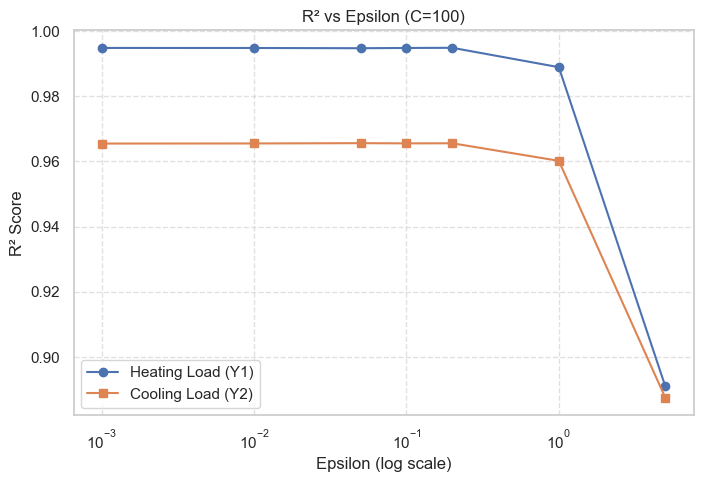

In [24]:
# === Collect metrics for R² vs epsilon ===
eps_values = [0.001, 0.01, 0.05, 0.1, 0.2, 1.0, 5.0]
r2_scores_y1 = []
r2_scores_y2 = []

for eps in eps_values:
    name = f"SVR (C=100, eps={eps})"
    Y_pred = Y_pred_svr_extended[name]
    r2_y1 = r2_score(Y_test[:,0], Y_pred[:,0])
    r2_y2 = r2_score(Y_test[:,1], Y_pred[:,1])
    r2_scores_y1.append(r2_y1)
    r2_scores_y2.append(r2_y2)

# === Plot R² vs epsilon ===
plt.figure(figsize=(8,5))
plt.plot(eps_values, r2_scores_y1, marker="o", label="Heating Load (Y1)")
plt.plot(eps_values, r2_scores_y2, marker="s", label="Cooling Load (Y2)")
plt.xscale("log")  # better visibility since eps spans several orders
plt.xlabel("Epsilon (log scale)")
plt.ylabel("R² Score")
plt.title("R² vs Epsilon (C=100)")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Benefits of SVR
*  **Handles high-dimensional data:** performs effectively even when there are many features
*  **Models non-linear relationships:** captures complex patterns with Kernel functions (like rbf or polynomial)
*  **Robust to small noises and outliers:** ignores errors within a defined margin (ε), making it less sensitive to minor noise
*  **Good generalization:** avoids overfitting by focusing on a subset of data points/support vectors 


# Limitations of SVR
*  **Training time complexity:**
*  **complexity in choosing hyperparameters:** finding right values for C, ε and Kernel parameters can be tricky and time consuming
*  **Not scalable to large datasets:** training time increases rapidly with number of samples
*  **Not easily interpretable:** output as complex function in kernel space is sometime difficult to understand



---

# Summary
- SVMs are powerful tools for both classification and regression.
- In regression, SVR uses the concept of an epsilon tube and support vectors to fit the data.
- Kernel functions allow SVMs to handle non-linear data.
- The parameters epsilon and C control the flexibility and tolerance of the SVR model.

**Thank you!**